# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4081.540385,1.0001,-131.886217,1896.59,1764.703783
OMUSDT,526.319895,1787.341565,0.4379,0.000000,1261.02,1261.020000
BTCUSDT,601.021649,872.033986,0.2137,3.537078,271.01,274.547078
JASMYUSDT,387.458505,525.532406,0.1288,0.000000,138.07,138.070000
SOLUSDT,281.200518,414.183202,0.1015,0.000000,132.98,132.980000
ETHUSDT,250.747339,268.061956,0.0657,0.000000,17.31,17.310000
TRXUSDT,76.868953,160.954777,0.0394,-10.723889,84.09,73.366111
BBUSDT,60.176053,52.175946,0.0128,-39.733101,-8.00,-47.733101
BNBUSDT,1.142121,1.256542,0.0003,-10.606040,0.11,-10.496040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-11-29    1338.021317
2024-11-30    1400.498824
2024-12-01    1387.700221
2024-12-02    1418.524583
2024-12-03    1806.096259
Name: Total, Length: 72, dtype: float64

In [24]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

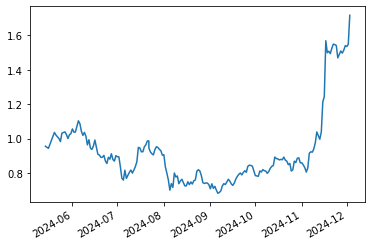

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MANAUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.7570
PEPEUSDT,0.2317
AAVEUSDT,0.0114
BONKUSDT,0.0000
WLDUSDT,0.0000
LDOUSDT,0.0000
AXSUSDT,0.0000
AVAXUSDT,0.0000
FETUSDT,0.0000
WBETHUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.325685
BTCUSDT,0.300000
TRXUSDT,0.131968
XLMUSDT,0.085841
PEPEUSDT,0.064112
BNBUSDT,0.047567
SUIUSDT,0.031083
JASMYUSDT,0.008127
XRPUSDT,0.005617


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.407595
OMUSDT,0.320642
TRXUSDT,0.271763


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1787.341565,0.437909,0.320642,0.117267
BTCUSDT,872.033986,0.213653,0.407595,-0.193942
JASMYUSDT,525.532406,0.128758,0.000000,0.000000
SOLUSDT,414.183202,0.101477,0.000000,0.000000
ETHUSDT,268.061956,0.065677,0.000000,0.000000
TRXUSDT,160.954777,0.039435,0.271763,-0.232328
BBUSDT,52.175946,0.012783,0.000000,0.000000
BNBUSDT,1.256542,0.000308,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1787.341565,0.437909,0.325685,0.112224
BTCUSDT,872.033986,0.213653,0.300000,-0.086347
JASMYUSDT,525.532406,0.128758,0.008127,0.120631
SOLUSDT,414.183202,0.101477,0.000000,0.000000
ETHUSDT,268.061956,0.065677,0.000000,0.000000
TRXUSDT,160.954777,0.039435,0.131968,-0.092533
BBUSDT,52.175946,0.012783,0.000000,0.000000
BNBUSDT,1.256542,0.000308,0.047567,-0.047259
PEPEUSDT,0.000005,0.000000,0.064112,-0.064112
XLMUSDT,0.000000,0.000000,0.085841,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

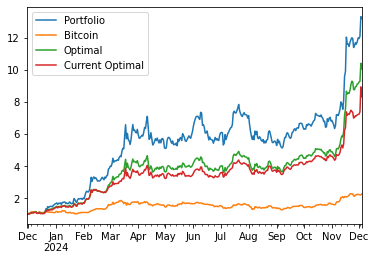

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

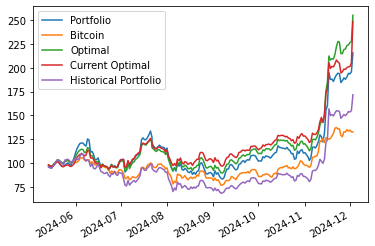

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-24,193.687305,135.911726,226.956851,204.716493,154.123725
2024-11-25,184.471870,128.947631,214.729869,194.418925,146.949156
2024-11-26,186.446201,127.490870,214.779820,195.844545,148.874744
2024-11-27,189.368786,132.783198,219.184984,198.578533,150.943684
2024-11-28,187.890058,132.479326,219.521848,198.261531,149.674755
2024-11-29,190.248721,134.971167,223.354444,200.018238,151.414174
2024-11-30,194.053810,133.506331,223.852543,200.987140,154.042164
2024-12-01,193.537411,134.578273,226.503366,201.225210,153.524639
2024-12-02,195.686318,132.703379,227.240182,205.142111,154.867822
2024-12-03,215.616664,132.715937,255.029169,248.582289,171.684779


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.575344
 dtype: float64,
 0.5760950595998495)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.638134
 dtype: float64,
 0.6381341424063084)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.710976
Bitcoin            0.436285
Optimal            0.576095
Current Optimal    0.555329
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.44740125411648435

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.083046,0.047567,0.006835,0.019352,0.001558,0.017795
BTCUSDT,0.381587,0.300000,0.035666,0.150190,0.051617,0.098573
JASMYUSDT,0.022343,0.008127,0.001594,0.006302,0.000229,0.006073
OMUSDT,16.849904,0.325685,0.898769,0.633088,0.527128,0.105960
PEPEUSDT,0.345314,0.064112,0.021425,0.071262,0.020015,0.051247
SUIUSDT,0.070003,0.031083,0.005290,0.020490,0.002630,0.017861
TRXUSDT,0.188516,0.131968,0.016770,0.053110,0.024125,0.028985
XLMUSDT,0.158398,0.085841,0.012781,0.043466,0.012926,0.030540
XRPUSDT,0.011016,0.005617,0.000870,0.002739,0.000040,0.002699


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.826309,0.320642,0.498239,0.549314,0.434414,0.114901
BTCUSDT,0.188009,0.407595,0.258732,0.184347,0.105340,0.079007
TRXUSDT,0.287691,0.271763,0.243029,0.266339,0.207740,0.058599


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.133900,0.44,0.661344,0.665158,0.542901,0.122257
BTCUSDT,0.096866,0.21,0.128943,0.085859,0.018558,0.067301
JASMYUSDT,0.067473,0.13,0.082977,0.121940,0.040794,0.081145
SOLUSDT,0.032547,0.10,0.055695,0.070071,0.010211,0.059860
ETHUSDT,0.011452,0.07,0.034226,0.032674,0.003592,0.029083
TRXUSDT,0.042344,0.04,0.034601,0.014098,0.002987,0.011111
BBUSDT,-0.004730,0.01,0.002214,0.010200,0.000396,0.009804


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04685710745030405, -0.06710687079440243)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04737591913204739, -0.06739376467118402)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017120
BTCUSDT     -0.010760
JASMYUSDT   -0.010558
SOLUSDT     -0.007623
ETHUSDT      0.001101
TRXUSDT     -0.002493
BBUSDT      -0.000124
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.047579
Name: 2024-11-25 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.038994
BTCUSDT     -0.007166
JASMYUSDT   -0.010618
SOLUSDT     -0.006599
ETHUSDT     -0.002609
TRXUSDT     -0.000657
BBUSDT      -0.000752
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067394
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.059692688190860696, -0.07650952214645036)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06612093221743716, -0.08474875367748132)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.053102714462065104, -0.06656642730281481)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06064553566441329, -0.07774062225490963)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.037981
BTCUSDT     -0.005537
JASMYUSDT   -0.008869
SOLUSDT     -0.004623
ETHUSDT     -0.002315
TRXUSDT     -0.000919
BBUSDT      -0.000792
Portfolio   -0.061035
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052522362300132276, -0.06769289953553935)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06117316101773621, -0.07786849122074282)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039362
BTCUSDT     -0.005497
JASMYUSDT   -0.008079
SOLUSDT     -0.004630
ETHUSDT     -0.002021
TRXUSDT     -0.000660
BBUSDT      -0.000686
Portfolio   -0.060934
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.052898480730568846, -0.0678106385420588)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06276468849568625, -0.0803056036100898)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.043020
BTCUSDT     -0.004389
JASMYUSDT   -0.006990
SOLUSDT     -0.004467
ETHUSDT     -0.001804
TRXUSDT     -0.000932
BBUSDT      -0.000663
Portfolio   -0.062265
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.09470868931607905, -0.13438318510337724)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11088005159196467, -0.15796279529666124)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.099386
BTCUSDT      0.000444
JASMYUSDT   -0.006396
SOLUSDT     -0.001744
ETHUSDT     -0.000340
TRXUSDT     -0.000455
BBUSDT      -0.000044
Portfolio   -0.107920
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0605631777491125, -0.07600181190853268)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0668782596063005, -0.08330862002627012)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.045585
BTCUSDT     -0.005488
JASMYUSDT   -0.008260
SOLUSDT     -0.004491
ETHUSDT     -0.002223
TRXUSDT     -0.000889
BBUSDT      -0.000681
Portfolio   -0.067617
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.047750,-0.082573,-0.068221,-0.024531
2024-01-15,-0.047750,-0.082569,-0.069395,0.013135
2024-01-16,-0.047750,-0.082359,-0.068686,0.038863
2024-01-17,-0.047750,-0.083856,-0.071992,-0.024207
2024-01-18,-0.047750,-0.085975,-0.071008,-0.032304
...,...,...,...,...
2024-11-30,-0.046166,-0.108002,-0.087292,0.002230
2024-12-01,-0.046166,-0.107769,-0.087687,0.011842
2024-12-02,-0.046166,-0.106699,-0.085132,0.003253
2024-12-03,-0.046166,-0.113055,-0.084609,0.122289


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034628,-0.084378,-0.078925,-0.017315
2024-05-29,-0.034628,-0.081761,-0.075777,-0.008690
2024-05-30,-0.034628,-0.071862,-0.068112,0.037743
2024-05-31,-0.034628,-0.072844,-0.064659,0.038574
2024-06-01,-0.034628,-0.076268,-0.070001,0.052520
...,...,...,...,...
2024-11-30,-0.046106,-0.137995,-0.121773,0.020001
2024-12-01,-0.046106,-0.138054,-0.121422,-0.002661
2024-12-02,-0.046106,-0.046907,-0.046249,0.011103
2024-12-03,-0.042738,-0.071652,-0.061200,0.101848


<AxesSubplot:>

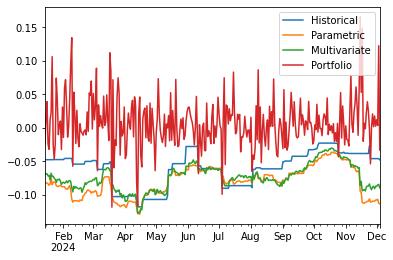

In [80]:
var_data.plot()

<AxesSubplot:>

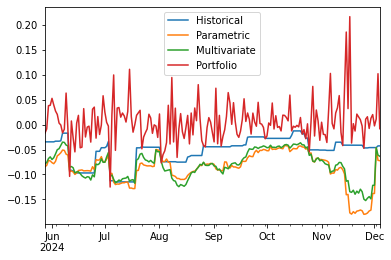

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021472,0.009202,0.01227
Kupiec Stat,7.042947,17.007844,13.843197
P-value,0.007958,0.000037,0.000199


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.062827,0.015707,0.015707
Kupiec Stat,0.614003,6.386075,6.386075
P-value,0.433285,0.011502,0.011502


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77197944, 0.07481947, 0.05640932, 0.05275215, 0.04403962])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014760
ADAUSDT     0.014887
ALGOUSDT    0.016817
APTUSDT     0.015510
ARBUSDT     0.016492
              ...   
WBTCUSDT    0.009410
WLDUSDT     0.021459
XLMUSDT     0.011891
XRPUSDT     0.010304
XTZUSDT     0.015744
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

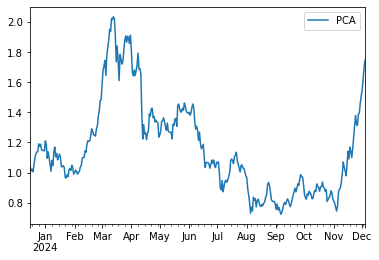

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

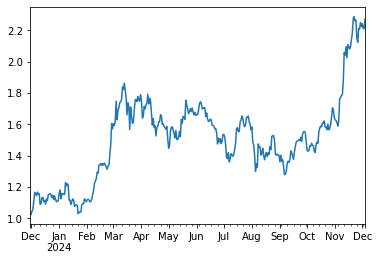

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.399295
WBETHUSDT    0.415052
ETHUSDT      0.415108
EGLDUSDT     0.415598
               ...   
FLOKIUSDT    1.113172
WLDUSDT      1.120314
BONKUSDT     1.123043
PEPEUSDT     1.153418
OMUSDT       1.526772
Length: 65, dtype: float64

<AxesSubplot:>

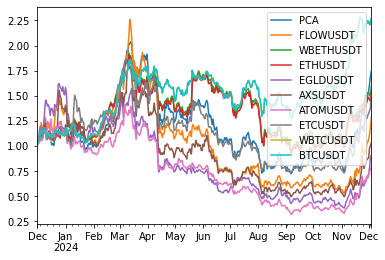

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

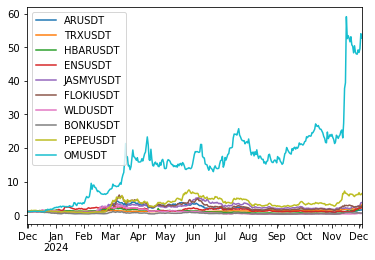

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.53950368, 0.15605331, 0.13395541, 0.10768161, 0.06280599])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.102019
BTCUSDT      0.063811
JASMYUSDT    0.158522
SOLUSDT      0.102997
ETHUSDT      0.084780
TRXUSDT      0.040575
BBUSDT       0.214430
BNBUSDT      0.067943
PEPEUSDT     0.164923
Name: PC1, dtype: float64

<AxesSubplot:>

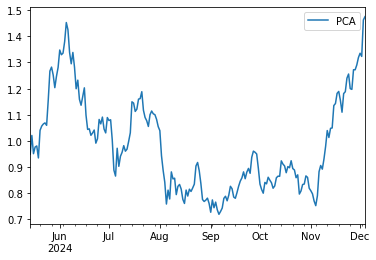

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

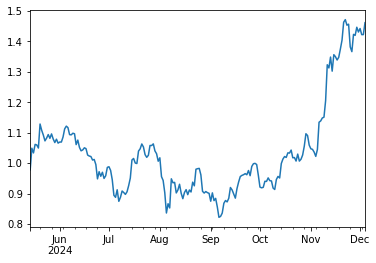

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.378808
ETHUSDT      0.388180
BNBUSDT      0.399119
BTCUSDT      0.405685
JASMYUSDT    0.540817
PEPEUSDT     0.660146
BBUSDT       0.701167
OMUSDT       0.861845
TRXUSDT      0.878498
dtype: float64

<AxesSubplot:>

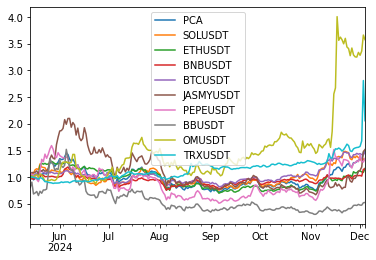

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.908785
BBUSDT       1.529527
JASMYUSDT    1.258155
SOLUSDT      1.146583
BTCUSDT      1.000000
ETHUSDT      0.948222
OMUSDT       0.876339
BNBUSDT      0.652034
TRXUSDT      0.236080
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.703720
SOLUSDT      1.324088
BTCUSDT      1.000000
ETHUSDT      0.928353
BNBUSDT      0.547844
BBUSDT       0.515890
JASMYUSDT    0.304114
OMUSDT      -0.237606
TRXUSDT     -0.688207
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table

,Beta
OMUSDT,0.050621
BTCUSDT,0.683579
JASMYUSDT,0.355928
SOLUSDT,-0.222470
ETHUSDT,0.243086
TRXUSDT,0.025639
BBUSDT,0.246152
BNBUSDT,-0.468362
PEPEUSDT,-0.018187


In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.5488741280878727

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.210196
BTCUSDT      1.208414
JASMYUSDT    0.475957
SOLUSDT      0.758519
ETHUSDT      0.926969
TRXUSDT      0.136282
BBUSDT       0.331222
BNBUSDT      1.069690
PEPEUSDT     0.372880
PCA          1.000000
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.130367
BTCUSDT      0.608492
JASMYUSDT    0.255875
SOLUSDT      0.504180
ETHUSDT      0.282366
TRXUSDT      0.045041
BBUSDT       0.393427
BNBUSDT      0.504157
PEPEUSDT     0.253616
PCA          1.000000
dtype: float64

In [104]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.297706,0.160827,0.353704,0.227852,0.129727,0.267479,0.207758,0.170674
BTCUSDT,0.297706,1.000000,0.511458,0.707322,0.789064,0.151905,0.553731,0.595095,0.655074
JASMYUSDT,0.160827,0.511458,1.000000,0.467605,0.500640,0.247841,0.602262,0.481116,0.398259
SOLUSDT,0.353704,0.707322,0.467605,1.000000,0.656149,0.173468,0.548072,0.512079,0.544589
ETHUSDT,0.227852,0.789064,0.500640,0.656149,1.000000,0.120455,0.601866,0.583462,0.642650
TRXUSDT,0.129727,0.151905,0.247841,0.173468,0.120455,1.000000,0.127231,0.298983,0.101824
BBUSDT,0.267479,0.553731,0.602262,0.548072,0.601866,0.127231,1.000000,0.579601,0.474443
BNBUSDT,0.207758,0.595095,0.481116,0.512079,0.583462,0.298983,0.579601,1.000000,0.416842
PEPEUSDT,0.170674,0.655074,0.398259,0.544589,0.642650,0.101824,0.474443,0.416842,1.000000


In [105]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.156131,0.285388,0.060835,-0.487066,0.691182,0.180524,0.371490,-0.322836
BTCUSDT,-0.156131,1.000000,0.081483,0.823329,0.568458,-0.085704,0.233721,0.337496,0.731010
JASMYUSDT,0.285388,0.081483,1.000000,0.377376,0.137714,0.643846,0.542612,0.774203,0.144961
SOLUSDT,0.060835,0.823329,0.377376,1.000000,0.526607,0.317996,0.571647,0.612626,0.722841
ETHUSDT,-0.487066,0.568458,0.137714,0.526607,1.000000,-0.254819,0.477554,0.203319,0.660258
TRXUSDT,0.691182,-0.085704,0.643846,0.317996,-0.254819,1.000000,0.385650,0.788854,-0.116650
BBUSDT,0.180524,0.233721,0.542612,0.571647,0.477554,0.385650,1.000000,0.593942,0.332480
BNBUSDT,0.371490,0.337496,0.774203,0.612626,0.203319,0.788854,0.593942,1.000000,0.329945
PEPEUSDT,-0.322836,0.731010,0.144961,0.722841,0.660258,-0.116650,0.332480,0.329945,1.000000


## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-04-28,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-05-28,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-06-27,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.950024,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-07-27,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.692256,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.067784,0.000000
2024-08-26,0.841934,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.158066,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-09-25,0.105757,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-10-25,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.758111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2024-11-24,0.013254,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.181259,0.087325,0.045976
2024-12-04,0.012920,0.0,0.015348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.141842,0.000000


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

STXUSDT     0.374547
TIAUSDT     0.252459
XRPUSDT     0.141842
LDOUSDT     0.129150
INJUSDT     0.050885
              ...   
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
IMXUSDT     0.000000
XTZUSDT     0.000000
Name: 2024-12-04 00:00:00, Length: 64, dtype: float64

<AxesSubplot:>

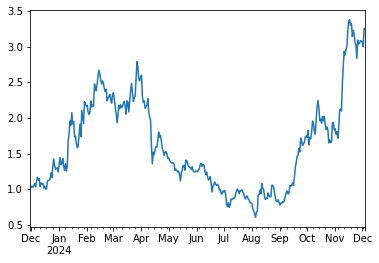

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()